<a href="https://colab.research.google.com/github/11kartheek/cifar/blob/main/KartheekB_s11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
!git clone https://github.com/11kartheek/ERA-v2.git

Cloning into 'ERA-v2'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 114 (delta 5), reused 1 (delta 1), pack-reused 103
Receiving objects: 100% (114/114), 244.37 KiB | 6.43 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [ ]:
%ls

ERA-v2/  sample_data/


In [ ]:

%cd ERA-v2/s10
# %cd ../..

/content/ERA-v2/s10


In [ ]:
%ls

kartheekB_S10.ipynb  models.py  README.md  utils.py


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy
from models import Net
from utils import train_transforms,test_transforms
import matplotlib.pyplot as plt
import numpy

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


# Dataset and Creating Train/Test Split

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        # A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        # A.RandomCrop(height=32, width=32, always_apply=True),
        # A.HorizontalFlip(),
        # A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [ ]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

In [ ]:
train_data = Cifar10SearchDataset('./data', train=True, download=True, transform=train_transforms)
test_data = Cifar10SearchDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=False) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? False


# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []



def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.cross_entropy(y_pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_losses.append(train_loss/len(train_loader))
  train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
def misclassifiedimages(model, device, test_loader,count = 10):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []  # List to store misclassified images
    misclassified_targets = []  # List to store misclassified targets
    misclassified_predictions = []  # List to store misclassified predictions

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Check for misclassified images
            misclassified_idx = ~pred.eq(target.view_as(pred)).squeeze()
            misclassified_data = data[misclassified_idx]
            misclassified_target = target[misclassified_idx]
            misclassified_pred = pred[misclassified_idx]
            misclassified_images.extend(misclassified_data.cpu().numpy())
            misclassified_targets.extend(misclassified_target.cpu().numpy())
            misclassified_predictions.extend(misclassified_pred.cpu().numpy())
            if len(misclassified_predictions) > count:
              break
    return misclassified_images,misclassified_targets,misclassified_predictions


In [ ]:
from torch.optim.lr_scheduler import StepLR
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  Net().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

from torch.optim.lr_scheduler import OneCycleLR

LRMIN = 0.001
LRMAX = 1.07
total_epochs = 24
max_at_epoch = 5

# One Cycle Policy scheduler
scheduler = OneCycleLR(optimizer, max_lr=LRMAX, epochs=total_epochs,
                       steps_per_epoch=len(train_loader), pct_start=max_at_epoch/total_epochs, anneal_strategy='linear',
                       div_factor=LRMAX/LRMIN, final_div_factor=LRMAX/LRMIN)

EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.649520754814148 Batch_id=44 Accuracy=31.53:   6%|▌         | 45/782 [02:49<46:11,  3.76s/it]


KeyboardInterrupt: 

In [ ]:
misclassified_images,misclassified_targets,misclassified_predictions = misclassifiedimages(model, device, test_loader,count = 10)

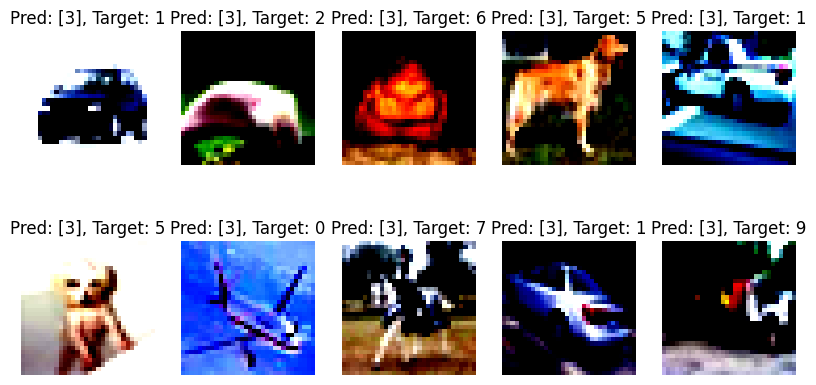

In [ ]:
num_misclassified = min(len(misclassified_images), 10)
plt.figure(figsize=(10, 5))
for i in range(num_misclassified):
    plt.subplot(2, 5, i + 1)
    plt.imshow(misclassified_images[i].transpose((1, 2, 0)))
    plt.title(f"Pred: {misclassified_predictions[i]}, Target: {misclassified_targets[i]}")
    plt.axis('off')
plt.show()

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [ ]:
import torch
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def denormalize_image(image):
    # Denormalize the image using means and standard deviations
    for i in range(3):  # Assuming RGB image
        image[i] = (image[i] * stds[i]) + means[i]
    return image

def visualize_gradcam(model, misclassified_images, misclassified_predictions, target_classes):
    for i, (image, pred, target) in enumerate(zip(misclassified_images, misclassified_predictions, target_classes)):
        if i > 9:
          break
        image_tensor = torch.from_numpy(image).unsqueeze(0).to(device)
        target_class = target

        # Initialize GradCAM
        cam = GradCAM(model=model,target_layers = [model.L2[-1]])

        # Compute Grad-CAM
        grayscale_cam = cam(input_tensor=image_tensor)

        image_for_vis = denormalize_image(image)
        # Visualize Grad-CAM
        visualization = show_cam_on_image(image_for_vis.transpose(1, 2, 0), grayscale_cam[0])

        # Plot Grad-CAM
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image_for_vis.transpose(1, 2, 0))
        plt.title(f"Predicted Class: {pred}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title(f'Grad-CAM on image {i}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


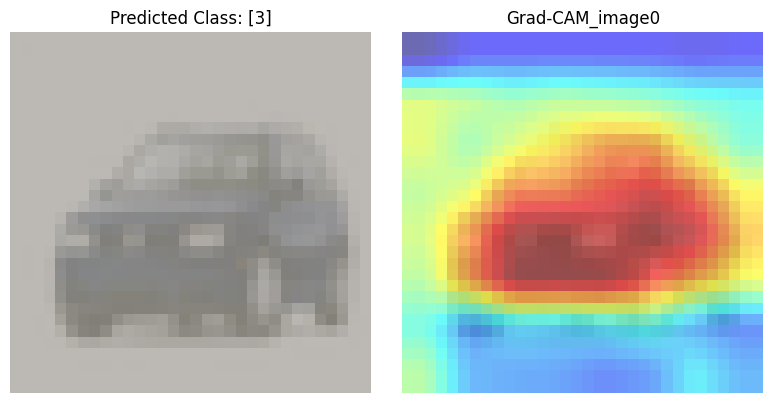

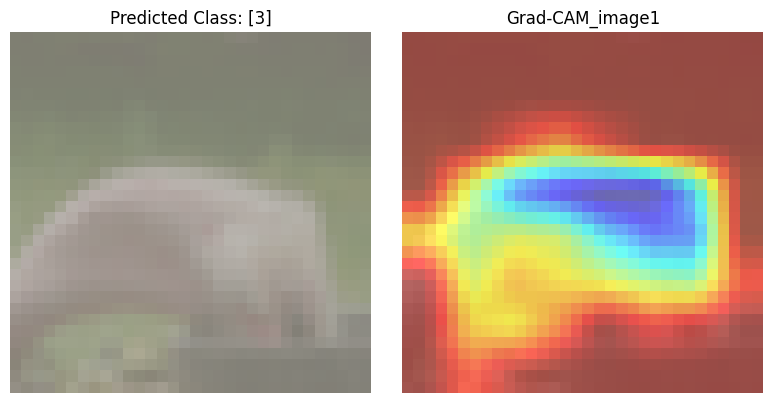

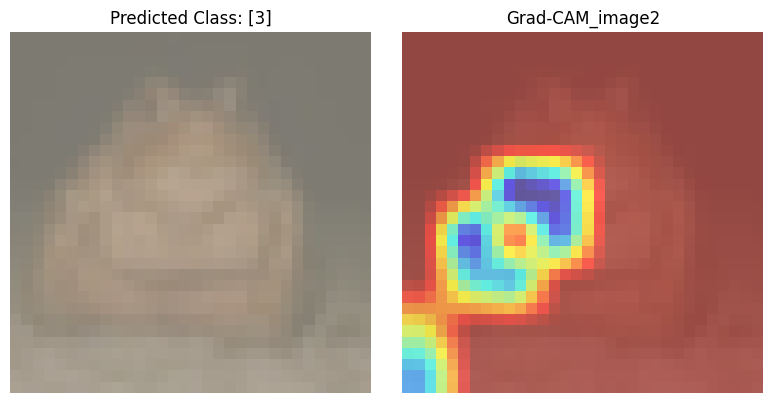

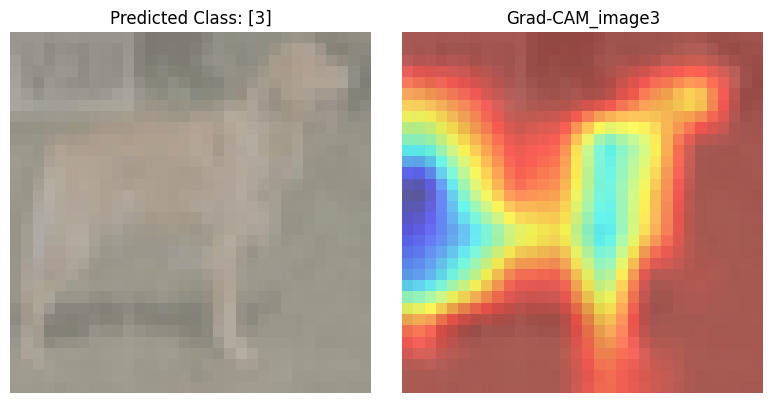

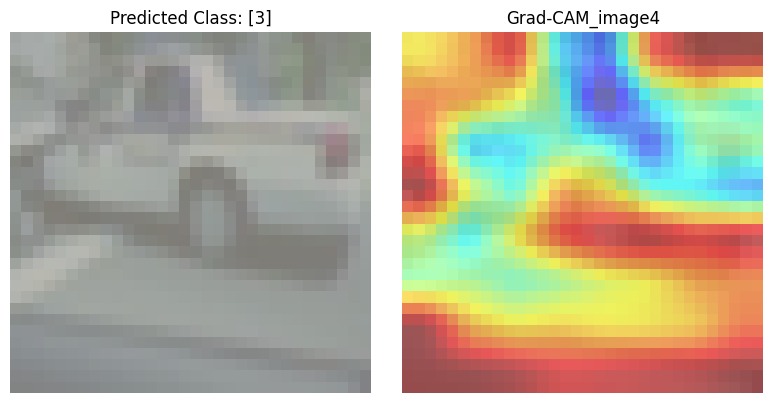

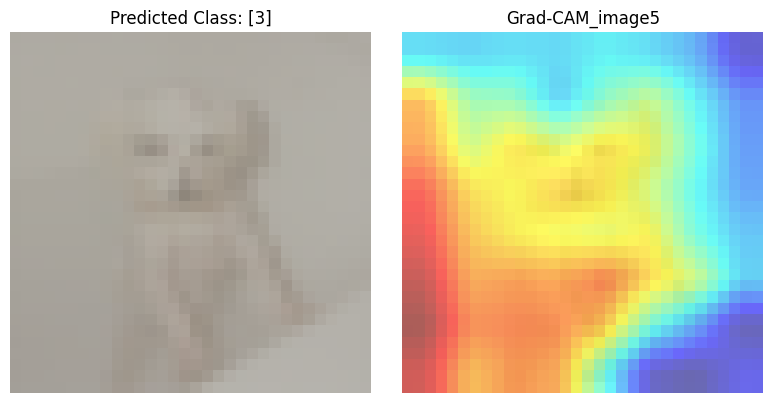

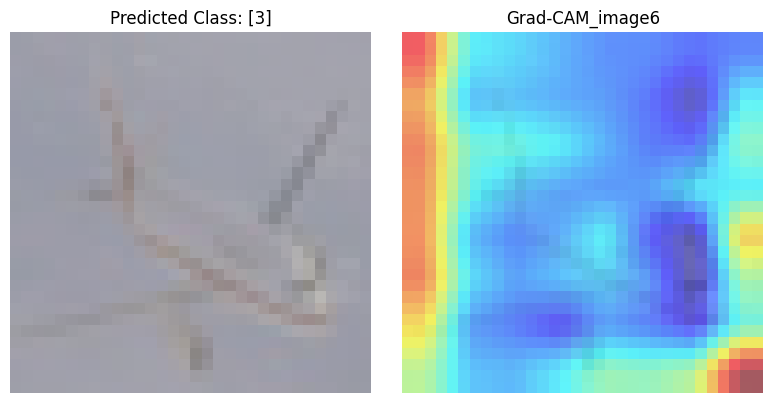

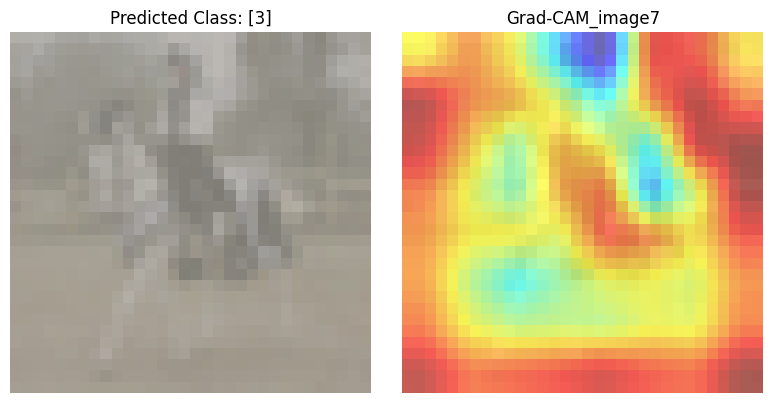

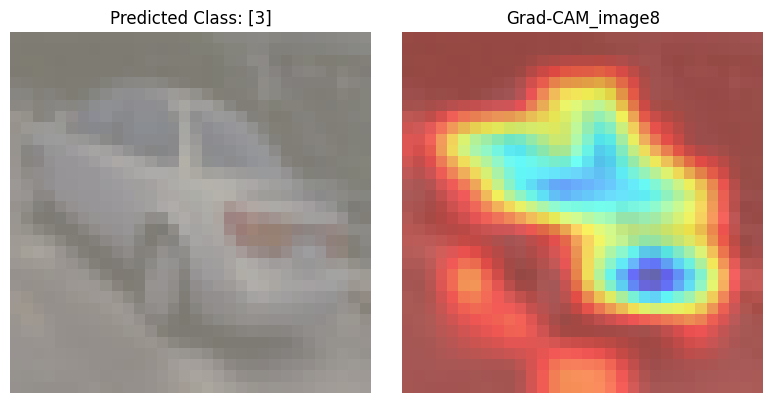

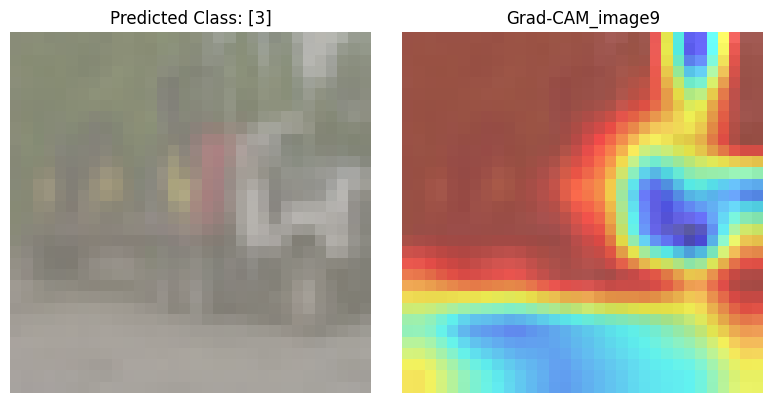

In [ ]:
visualize_gradcam(model, misclassified_images, misclassified_predictions, misclassified_targets )


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
# from gradcam.utils import visualize_cam
target_layers = [model.L2[-1]]
input_tensor = misclassified_images[0]
input_tensor = torch.from_numpy(input_tensor).unsqueeze(0).to(device)# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

target_class = torch.tensor([misclassified_targets[0]]).to(device)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=target_class)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(misclassified_images[0].transpose((1, 2, 0)), grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs

TypeError: 'Tensor' object is not callable

Text(0.5, 1.0, 'Test Accuracy')

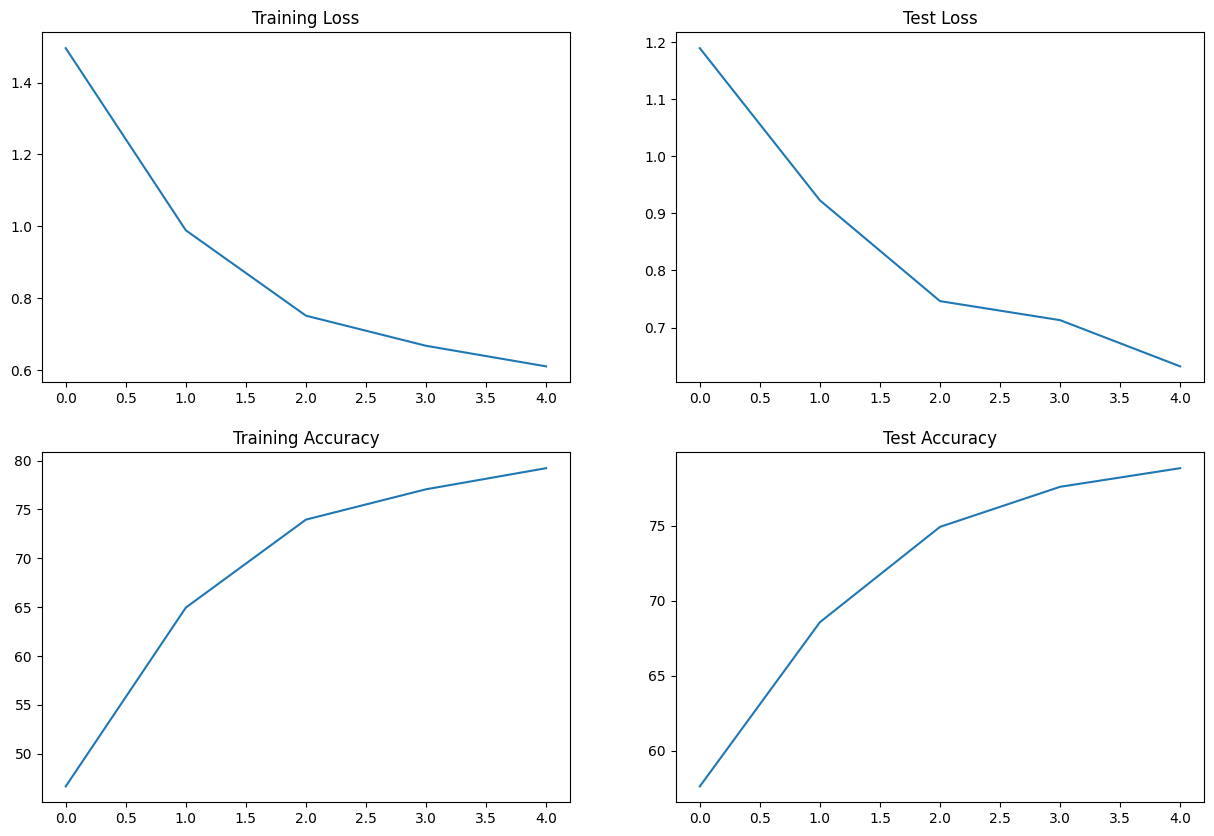

In [ ]:
import matplotlib.pyplot as plt
import numpy
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torch-lr-finder

In [ ]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
model =  Net().to(device)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()